# Spectral Graph Bipartitioning

Many data clustering problems can be interpreted as clustering of vertices of graphs.
__Graph bipartitioning problem__ is to partition vertices into subsets such that the connections within subsets are stronger than the connections between different subsets.

Partition of the vertices into two subsetts is done according to signs of the eigenvectors of the second smallest eigenvalue of the Laplacian matrix. 

## Prerequisites

The reader should be familiar with the basic graph theory, linear algebra and, in particular,  eigenvalues and eigenvectors.
 
## Competences 

The reader should be able to apply graph spectral bipartitioning and recursive bipartitioning to data clustering problems.

__Credits__: The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: #1 "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, University of Zagreb, 2005 (in Croatian)." 

## Graphs

For more details, see 
[W. H. Haemers, Matrices and Graphs][Hog14]
and [S. Butler and F. Chung, Spectral Graph Theory][Hog14a]
and the references therein.

[Hog14]: #1 "L. Hogben, ed., 'Handbook of Linear Algebra', pp. 39.1-39.14, CRC Press, Boca Raton, 2014."

[Hog14a]: #1 "L. Hogben, ed., 'Handbook of Linear Algebra', pp. 47.1-47.6, CRC Press, Boca Raton, 2014."

### Definitions

A __weighted graph__ is an ordered triplet $G=(V,E,\omega)$, where $V=\{1,2,3,...,n\}$ is the set of __vertices__ , $E=\{(i,j)\}$ is a set of __edges__ connecting vertices, and $\omega$ is a set of __weights__ of edges. We assume $G$ is undirected.

An __adjacency matrix__ of graph $G$ is the matrix $A$ defined as
$A_{ij}=\begin{cases} 1 \quad \textrm{if}\ (i,j)\in E, \\
0\quad  \textrm{otherwise} \end{cases}.$

A __weight matrix__ of graph $G$ is the matrix $W$ defined as
$W_{ij}=\begin{cases} \omega(e) \quad \textrm{if}\ e=(i,j)\in E, \\
0\quad  \textrm{otherwise} \end{cases}.$

A __Laplacian matrix__ of graph $G$ is the matrix $L=D-W$, where 
$D=\mathop{\mathrm{diag}}(d_1,d_2,\ldots,d_n)$ with $d_i=\sum_{k=1}^n W_{ik}$ for $i=1,\ldots,n$.

A __normalized Laplacian matrix__ is the matrix 
$L_n=D^{-1/2} L D^{-1/2}\equiv D^{-1/2} (D-W) D^{-1/2}$ (_the scaled matrix of $L$_).

An __incidence matrix__ of graph $G$ is the $|V|\times |E|$ matrix $I_G$. Each row of $I:G$ corresponds to a vertex of $G$ and each column corresponds to an edge of $G$.
In the column corresponding to en edge $e=(i,j)$, all elements are zero except the ones in the $i$-th and $j$-th row, which are equal to $\sqrt{\omega(e)}$ and $-\sqrt{\omega(e)}$, respectively.

### Examples

Graph types and algorithms are implemented in the package [LightGraphs.jl](https://github.com/JuliaGraphs/LightGraphs.jl). 

Plotting graphs is done by the packages
[GraphPlot.jl](https://github.com/JuliaGraphs/GraphPlot.jl).

As a small inconvenience, we can only plot unweighted graphs and plot weights as node labels.

In [1]:
using LightGraphs
using GraphPlot

In [2]:
# whos(LightGraphs)

In [3]:
# Sources, targets and weights
n=7
sn=[1,1,1,2,2,3,3,3,5,5,6]
tn=[2,3,4,4,5,4,6,7,6,7,7]
wn=[2,3,4,7,1,3,2,1,7,3,5]
[sn tn wn]

11×3 Array{Int64,2}:
 1  2  2
 1  3  3
 1  4  4
 2  4  7
 2  5  1
 3  4  3
 3  6  2
 3  7  1
 5  6  7
 5  7  3
 6  7  5

In [4]:
# Create the graph
G=Graph(n)
for i=1:length(sn)
    add_edge!(G,sn[i],tn[i])
end
G

{7, 11} undirected simple Int64 graph

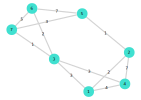

In [5]:
# What is the optimal bipartition?
gplot(G, nodelabel=1:n, edgelabel=wn)

In [6]:
# Now some functions
function my_weight_matrix(src::Array,dst::Array,weights::Array)
    n=nv(G)
    sparse([src;dst],[dst;src],[weights;weights],n,n)
end

my_laplacian(W::AbstractMatrix)=sparse(diagm(vec(sum(W,2))))-W

function my_normalized_laplacian(L::AbstractMatrix)
    D=1.0./sqrt.(diag(L))
    n=length(D)
    [L[i,j]*(D[i]*D[j]) for i=1:n, j=1:n]
end

my_normalized_laplacian (generic function with 1 method)

In [7]:
W=my_weight_matrix(sn,tn,wn)

7×7 SparseMatrixCSC{Int64,Int64} with 22 stored entries:
  [2, 1]  =  2
  [3, 1]  =  3
  [4, 1]  =  4
  [1, 2]  =  2
  [4, 2]  =  7
  [5, 2]  =  1
  [1, 3]  =  3
  [4, 3]  =  3
  [6, 3]  =  2
  [7, 3]  =  1
  ⋮
  [2, 4]  =  7
  [3, 4]  =  3
  [2, 5]  =  1
  [6, 5]  =  7
  [7, 5]  =  3
  [3, 6]  =  2
  [5, 6]  =  7
  [7, 6]  =  5
  [3, 7]  =  1
  [5, 7]  =  3
  [6, 7]  =  5

In [8]:
full(W)

7×7 Array{Int64,2}:
 0  2  3  4  0  0  0
 2  0  0  7  1  0  0
 3  0  0  3  0  2  1
 4  7  3  0  0  0  0
 0  1  0  0  0  7  3
 0  0  2  0  7  0  5
 0  0  1  0  3  5  0

In [9]:
L=my_laplacian(W)
full(L)

7×7 Array{Int64,2}:
  9  -2  -3  -4   0   0   0
 -2  10   0  -7  -1   0   0
 -3   0   9  -3   0  -2  -1
 -4  -7  -3  14   0   0   0
  0  -1   0   0  11  -7  -3
  0   0  -2   0  -7  14  -5
  0   0  -1   0  -3  -5   9

In [10]:
Ln=my_normalized_laplacian(L)

7×7 Array{Float64,2}:
  1.0       -0.210819   -0.333333  …   0.0         0.0        0.0     
 -0.210819   1.0         0.0          -0.0953463   0.0        0.0     
 -0.333333   0.0         1.0           0.0        -0.178174  -0.111111
 -0.356348  -0.591608   -0.267261      0.0         0.0        0.0     
  0.0       -0.0953463   0.0           1.0        -0.564076  -0.301511
  0.0        0.0        -0.178174  …  -0.564076    1.0       -0.445435
  0.0        0.0        -0.111111     -0.301511   -0.445435   1.0     

In [11]:
issymmetric(Ln)

true

In [12]:
# Let us compute the incidence matrix
function my_incidence_matrix(G::Graph, weights::Array)
    A=zeros(nv(G),ne(G))
    k=1
    for a in edges(G)
        A[a.dst,k]=sqrt.(weights[k])
        A[a.src,k]=-sqrt(weights[k])
        k+=1
    end
    A
end

my_incidence_matrix (generic function with 1 method)

In [13]:
Iᵧ=my_incidence_matrix(G,wn)

7×11 Array{Float64,2}:
 -1.41421  -1.73205  -2.0   0.0      …   0.0   0.0       0.0       0.0    
  1.41421   0.0       0.0  -2.64575      0.0   0.0       0.0       0.0    
  0.0       1.73205   0.0   0.0         -1.0   0.0       0.0       0.0    
  0.0       0.0       2.0   2.64575      0.0   0.0       0.0       0.0    
  0.0       0.0       0.0   0.0          0.0  -2.64575  -1.73205   0.0    
  0.0       0.0       0.0   0.0      …   0.0   2.64575   0.0      -2.23607
  0.0       0.0       0.0   0.0          1.0   0.0       1.73205   2.23607

### Facts

1. $L=I_{G}I_{G}^{T}$.

2. $L$ is symmetric PSD matrix.

3. $L\mathbf{1}=0$ for $\mathbf{1}=[1,...,1]^{T}$, thus $0$ is an eigenvalue of $L$ 
and $\mathbf{1}$ is the corresponding eigenvector.

4. If $G$ has $c$ connected components, then $L$ has $c$ eigenvalues equal to $0$.

5. For every $x\in \mathbb{R}^{n}$, it holds
$x^{T}L x=\sum\limits_{i<j}W_{ij}(x_{i}-x_{j})^{2}$.

6. For every $x\in\mathbb{R}^{n}$ and $\alpha,\beta\in\mathbb{R}$, it holds
$(\alpha x+\beta \mathbf{1})^{T} L (\alpha x+\beta \mathbf{1}) 
=\alpha^{2} x^{T}L x$.

7. Assume that the eigenvalues of $L$ are increasingly ordered. 
Then, 
$$
0=\lambda_1(L)\leq \lambda_2(L)\leq \cdots \leq\lambda_{n}(L)\leq 
2\max\limits_{i=1,\cdots ,n}d_{i}.
$$

8. $\sigma(L_n) \subseteq [0,2]$.

### Examples

In [14]:
# Fact 1
vecnorm(L-Iᵧ*Iᵧ')

3.607797795906347e-15

In [15]:
# Facts 2 and 7
issymmetric(L), eigs(L)[1], 2*maximum(diag(L))

(true, [20.3183, 20.0518, 12.6913, 12.4888, 8.50014, 1.9497], 28)

In [16]:
# Fact 3
L*ones(n)

7-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [17]:
# Fact 5
x=rand(n)
x'*L*x, sum([W[i,j]*(x[i]-x[j])^2 for i=1:n, j=1:n])/2

(8.820471897028595, 8.820471897028597)

In [18]:
# Fact 6
α,β=rand(),rand()
(α*x+β*ones(n))'*L*(α*x+β*ones(n)), α^2*x'*L*x

(6.990540525195519, 6.990540525195518)

In [19]:
# Fact 8
eigvals(Ln)

7-element Array{Float64,1}:
 2.18575e-16
 0.17559    
 0.887695   
 1.29       
 1.3692     
 1.62123    
 1.65628    

## Bipartitioning

### Definitions

Let $\pi=\{V_{1},V_{2}\}$ be a partition of $V$ with $V_1,V_2\neq \emptyset$.

A __cut__ of a partition $\pi$ is the sum of weights of all 
edges between $V_1$ and $V_2$, 

$$cut(\pi)\equiv cut(V_1,V_2)=\sum\limits_{{\displaystyle i\in V_{1} \atop \displaystyle j\in V_{2}}}W_{ij}.$$

A __weight__ of a vertex $i\in V$ is the sum of the weights of all egdges emanating from $i$,
$\omega(i)=\sum\limits_{j=1}^{n}W_{ij}$.

A __weight__ of a subset $\bar V\subset V$ is the sum of the weights of all vertices in 
$\bar V$, $\omega(\bar V)=\sum\limits_{\displaystyle i\in\bar V} \omega(i)$.

A __proportional cut__ of a partition $\pi$ is

$$
pcut(\pi)=\displaystyle\frac{cut(\pi)}{|V_{1}|}+\frac{cut(\pi)}{|V_{2}|}.
$$

A __normalized cut__ of a partition $\pi$ is

$$
ncut(\pi)=\displaystyle\frac{cut(\pi)}{\omega(V_{1})}+\frac{cut(\pi)}{\omega(V_{2})}.
$$

### Example

Consider the following partitions (all edges have unit weights):

![Two partitions](files/cut2.png)

The left partition $\pi$ v.s. the right partition $\pi^{\prime}$:

$cut(\pi)=2$ v.s. $cut(\pi^{\prime})=3$

$pcut(\pi)=\frac{2}{1}+\frac{2}{11}=2.18$ v.s. 
$pcut(\pi^{\prime})=\frac{3}{6}+\frac{3}{6}=1$

$ncut(\pi)=\frac{2}{2}+\frac{2}{50}=1.04$ v.s. 
$ncut(\pi^{\prime})=\frac{3}{27}+\frac{3}{25}=0.23$

### Facts

1. The informal description of the bipartitioning problem can be formulated as
two problems,
$$
\mathop{\textrm{arg min}}\limits_{\pi} pcut(\pi) \quad \textrm{or} \quad 
\mathop{\textrm{arg min}}\limits_{\pi} ncut(\pi).
$$
The first problem favors partitions into subsets with similar numbers of vertices, while the second problem favors partitions into subsets with similar weights.

2. Both problems are NP-hard.

3. Approximate solutions can be computed by suitable relaxations in $O(n^2)$ operations.

4. The partition $\pi$ is defined by the vector $y$ such that
$$
y_{i}=
\begin{cases}
\frac{1}{2} & \text{for } i\in V_1 \\
-\frac{1}{2} & \text{for } i\in V_2
\end{cases}
$$
The proportional cut problem can be formulated as the  __discrete__ proportional cut problem
$$
\underset{\displaystyle \big|\mathbf{y}^{T}\mathbf{1} \big|\leq \beta}
{\min\limits_{\displaystyle y_{i}\in \{-1/2,1/2\}}}
\frac{1}{2}\sum_{i,j}(y_{i}-y_{j})^{2}W_{ij}.
$$
Parameter $\beta$ controls the number of vertices in each subset.

3. The normalized cut problem can be formulated as the __discrete__ normalized cut problem
$$
\underset{\displaystyle \big|y^{T}D\mathbf{1} \big|\leq \beta}
{\min\limits_{\displaystyle y_{i}\in \{-1/2,1/2\}}}
\frac{1}{2}\sum_{i,j}(y_{i}-y_{j})^{2}W_{ij}.
$$
Parameter $\beta$ controls the weights of each subset.

4. Using the Fact 5 above, the discrete proportional cut problem can be 
formulated as the __relaxed__ proportional cut problem
$$
\underset{\displaystyle y^{T}y=1}{\underset{\displaystyle \big| y^{T}\mathbf{1} \big|
\leq 2\frac{\beta}{\sqrt{n}}}
{\min\limits_{\displaystyle y\in \mathbb{R}^{n}}}} y^{T}L y.
$$
Similarly, the discrete normalized cut problem can be formulated as the __relaxed__
normalized cut problem
$$
\underset{\displaystyle y^{T}Dy=1}{\underset{\displaystyle \big| y^{T}D\mathbf{1}\big|
\leq \displaystyle \frac{\beta}{\sqrt{\theta n}}}{\min\limits_{\displaystyle y\in
\mathbb{R}^{n}}}}y^{T}L_n y.
$$

5. __The Main Theorem.__
Let $A\in \mathbb{R}^{n\times n}$ be a symmetric matrix with eigenvalues
$\lambda _{1}<\lambda _{2}<\lambda_{3}\leq \cdots \leq \lambda _{n}$ and let 
$v^{[1]},v^{[2]},\ldots,v^{[n]}$ be the corresponding eigenvectors. 
For the fixed $0\leq \alpha <1$, the solution of the problem
$$
\underset{\displaystyle y^{T}y=1}{\underset{\displaystyle \left|y^{T}v^{[1]}\right|\leq \alpha}
{\min\limits_{\displaystyle y\in \mathbb{R}^{n}}}} y^{T}Ay
$$
is $y=\pm \alpha v^{[1]}\pm \sqrt{1-\alpha^{2}}v^{[2]}$. 
_(For the proof see [D. J. Higham and M. Kibble, A Unified View of Spectral Clustering][HK04].)_

6. For $0\leq \beta <\frac{n}{2}$, the solution of the relaxed proportional cut problem is 
$$
y=\pm \frac{2\beta}{n\sqrt{n}}\mathbf{1}\pm
\sqrt{1-4\frac{\beta ^{2}}{n^{2}}}v^{[2]},
$$
where $v^{[2]}$ is an eigenvector corresponding to $\lambda_2(L)$.
$v^{[2]}$ the __Fiedler vector__. Since the first summand carries no information, 
$V$ is partitioned according to the signs of the components of $v^{[2]}$:
$$
V_{1}=\{i:v^{[2]}_i <0\}, \quad V_{2}=\{i:v^{[2]}_i \geq 0\}.
$$
_Notice that the value of $\beta$ is irrelevant for the solution._

7. For $0\leq \beta <\sqrt{\theta n}\left\Vert
D^{\frac{1}{2}}\mathbf{1} \right\Vert _{2}$, 
the solution of the relaxed proportional cut problem is
$$
y=\pm \frac{\beta }{\sqrt{\theta n}\left\Vert
D^{\frac{1}{2}} \mathbf{1}\right\Vert _{2}^{2}}\mathbf{1}\pm
\sqrt{1-\frac{\beta ^{2}}{ \theta n\left\Vert
D^{\frac{1}{2}}\mathbf{1}\right\Vert _{2}^{2}}}D^{-\frac{1
}{2}} v^{[2]},
$$
where $v^{[2]}$ is an eigenvector corresponding to $\lambda_2(L_n)$.
$V$ is partitioned according to the signs of the components of $v^{[2]}$, as above.

9. Neither of the relaxed algorithms is guaranteed to solve exactly the true (proportional / normalized) cut problem. However, the computed solutions are in the right direction. 
Whether to use proportional or normalized cut formulation, depends upon the specific problem.  

[HK04]: #1 "D. J. Higham and M. Kibble, A Unified View of Spectral Clustering, Mathematics Research Report 2, University of Strathclyde(2004)"

In [20]:
# Voila!
λ,v=eigs(L,nev=2,which=:SM, v0=ones(n))

([2.53765e-16, 1.9497], [-0.377964 -0.383259; -0.377964 -0.373084; … ; -0.377964 0.408506; -0.377964 0.449408], 2, 1, 7, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [21]:
v

7×2 Array{Float64,2}:
 -0.377964  -0.383259
 -0.377964  -0.373084
 -0.377964  -0.145189
 -0.377964  -0.380089
 -0.377964   0.423708
 -0.377964   0.408506
 -0.377964   0.449408

In [22]:
λ,v=eigs(Ln,nev=2,which=:SM, v0=ones(n))

([2.62948e-17, 0.175846], [-0.344124 0.338025; -0.362738 0.361066; … ; -0.429198 -0.457099; -0.344124 -0.388252], 2, 1, 7, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [23]:
v

7×2 Array{Float64,2}:
 -0.344124   0.338025
 -0.362738   0.361066
 -0.344124   0.126062
 -0.429198   0.45732 
 -0.380443  -0.413108
 -0.429198  -0.457099
 -0.344124  -0.388252

### Example - Concentric circles

A __complete graph__ has edges connecting each pair of vertices.

To a set of points $X=\{x_{1},x_{2},\cdots ,x_{m}\}$ , where $x_{i}\in\mathbb{R}^{n}$, we assign a weighted complete graph $G=(V,E)$ with $m$ vertices, where the vertex $j\in V$ corresponds to the point $x_j\in X$.

The main idea is to assign weight of an edge $e=(i,j)$ which reflects the distance between $x_i$ and $x_j$, something like $\omega(e)=\displaystyle\frac{1}{\mathop{\mathrm{dist}}(x_i,x_j)}$.

However, this has to be implemented with care. For example, using simple Euclidean distance yield the same results as the function `kmeans()`. In this example we use Gaussian kernel, that is 
$$
\omega(e)=e^{\displaystyle -\|x_i-x_j\|_2^2/\sigma^2},
$$
where the choice of $\sigma$ is based on experience.

The computation of various distances is implemented in the package 
[Distances.jl](https://github.com/JuliaStats/Distances.jl).

We will construct the Laplace matrix directly.

In [24]:
using Winston
using Colors
using Distances

In [25]:
# Generate two concentric rings
k=2
s=srand(421)
# Center
center=[rand(-5:5);rand(-5:5)]
# Radii
radii=randperm(10)[1:k]
# Number of points in circles
sizes=rand(1000:2000,k)
center,radii,sizes

([4, -3], [8, 5], [1932, 1087])

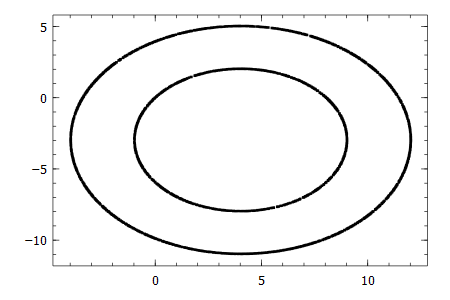

In [26]:
# Points
m=sum(sizes)
X=Array{Float64}(2,m)
first=0
last=0
for j=1:k
    first=last+1
    last=last+sizes[j]
    # Random angles
    ϕ=2*π*rand(sizes[j])
    for i=first:last
        l=i-first+1
        X[:,i]=center+radii[j]*[cos(ϕ[l]);sin(ϕ[l])]+(rand(2)-0.5)/50
    end
end
Winston.plot(X[1,:],X[2,:],".")

In [27]:
# Weight matrix
W=1./pairwise(SqEuclidean(),X)

3019×3019 Array{Float64,2}:
 Inf             0.00418092    0.0261603   …    0.00926805    0.00881127
   0.00418092  Inf             0.00398155       0.0292591     0.0333644 
   0.0261603     0.00398155  Inf                0.00633556    0.00623409
   0.0109957     0.0100555     0.00528231       0.0502006     0.0431003 
   0.00425747    3.42547       0.00394519       0.0328617     0.0376928 
   0.0116045     0.00446525    0.0802536   …    0.00592752    0.00592787
   0.0150258     0.00421916    0.205658         0.00600517    0.00596938
   0.491721      0.00402425    0.042678         0.00824227    0.00790531
   0.00469215    0.14656       0.0039043        0.0544282     0.0632514 
   0.0259226     0.00398746  843.465            0.0063357     0.0062352 
   0.00396635    0.234242      0.00419201  …    0.0195692     0.0217929 
   0.0646146     0.00512018    0.0108097        0.01463       0.0134907 
   0.00503543    0.00836607    0.00986126       0.00695682    0.007199  
   ⋮                   

In [28]:
# Laplacian matrix
for i=1:m
    W[i,i]=0
end
L=diagm(vec(sum(W,2)))-W
# Check Fact 3
norm(L*ones(m))

5.713090892454398e-8

In [29]:
# Notice λ₁
λ,v=eigs(L,nev=2,which=:SM, v0=ones(m))

([-3.01755e-11, 29.5083], [0.0181999 -0.0190234; 0.0181999 0.00830624; … ; 0.0181999 -0.0111814; 0.0181999 -0.00979562], 2, 2, 37, [-2.96059e-5, -0.000129115, 6.12472e-5, 1.10377e-5, -9.4272e-5, -7.3308e-5, 3.65476e-5, -8.72772e-5, -1.91873e-5, 5.52403e-5  …  1.85439e-6, -1.46982e-5, -1.64972e-5, 3.03724e-5, 1.52168e-5, -2.00014e-5, -6.9125e-6, -1.31319e-5, -4.09204e-5, -1.7816e-5])

In [30]:
# Define clusters
C=ones(Int64,m)
C[find(v[:,2].>0)]=2

2

In [31]:
# Yet another plotting function
function plotKpartresult(C::Vector,X::Array)
    p=FramedPlot()
    k=maximum(C)
    for j=1:k
        # Random color
        col=RGB(rand(),rand(),rand())
        p1=Points(X[1,find(C.==j)],
        X[2,find(C.==j)],"color",col,symbolkind="dot")
        add(p,p1)
    end
    p
end

plotKpartresult (generic function with 1 method)

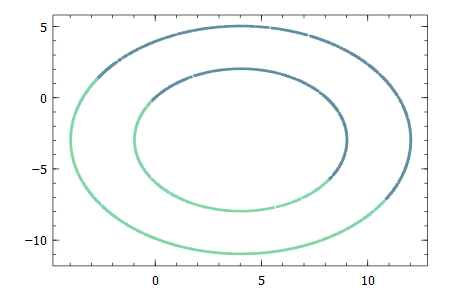

In [32]:
plotKpartresult(C,X)

This is the same partitioning as obtained by `kmeans()`. Let us try Gaussian kernel. A rule of thumb is: if rings are close, use $\sigma<1$, if rings are apart, use $\sigma>1$.

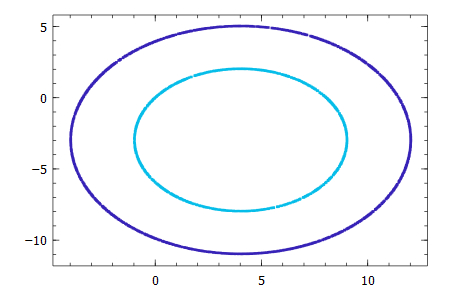

In [33]:
σ=1.0 # 0.1
W=exp.(-pairwise(SqEuclidean(),X)/σ^2)-I
L=diagm(vec(sum(W,2)))-W
λ,v=eigs(L,nev=2,which=:SM, v0=ones(m))
C=ones(Int64,m)
C[find(v[:,2].>0)]=2
plotKpartresult(C,X)

## Recursive bipartitioning

### Definitions

Let $G=(V,E)$ be a weighted graph with weights $\omega$.

Let $\pi_k =\{V_{1},V_{2},...,V_{k}\}$ be a $k$-partition of $V$, with 
$V_i\neq \emptyset$ for $i=1,\ldots,k$.

The previous definition of $cut(\pi)\equiv cut(\pi_2)$ extends naturally to $k$-partition.
A __cut__ of a partition $\pi_k$ is 

$$
cut(\pi_k)=\sum\limits_{\displaystyle i<j} cut(V_{i},V_{j}),
$$

where $cut(V_{i},V_{j})$ is interpreted as a cut of the bipartition of the subgraph of $G$ with vertices $V_1\cup V_2$.

A __proportional cut__ of a partition $\pi_k$ is

$$
pcut(\pi_k)=\underset{i<j}{\sum\limits_{i,j=1}^{k}} \left(
\frac{cut(V_{i},V_{j})}{|V_{i}|}+\frac{cut(V_{i},V_{j})}{|V_{j}|}\right) =
\sum_{i=1}^{k}\frac{cut(V_{i},V\backslash V_{i})}{|V_{i}|}.
$$

A __normalized cut__ of a partition $\pi_k$ is

$$
ncut(\pi_k)=\underset{i<j}{\sum\limits_{i,j=1}^{k}} \left(
\frac{cut(V_{i},V_{j})}{\omega(V_{i})}+\frac{cut(V_{i},V_{j})}{\omega(V_{j})}\right) =
\sum_{i=1}^{k}\frac{cut(V_{i},V\backslash V_{i})}{ \omega(V_{i})}.
$$

### Fact

If we want to cluster vertices of graph $G=(V,E)$ into $k$ clusters, we can apply the following recursive algorithm:

1. __Initialization.__ Compute the bipartition $\pi=\{V_{1},V_{2}\}$ of $V$. 
Set the counter $c=2$.

2. __Recursion.__ While $c<k$ repeat:

    1. Compute the bipartition of each subset of $V$.
    
    2. Among all $(c+1)$-partitions, choose the one with the smallest $pcut(\pi_{c+1})$ or
    $ncut(\pi_{c+1})$, respectively.
    
    3. Set $c=c+1$.

3. __Stop.__

_There is no guarantee for optimality of this algorithm. Clearly, the optimal $k$-partiton may be a subpartition of one of the discarded partitions._